In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from epftoolbox.evaluation import rMAE
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from jupyterthemes import jtplot

jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)
sns.set()

Importando datos históricos de precio y demanda obtenidos del sitio web del CENACE

In [24]:
datosraw = pd.read_csv('Gas_PML_Daily_2018_22.csv')
data = datosraw.copy()
data = data.drop(columns=['Date'])
df_dateindex = pd.date_range(start='2018-01-02', end='2022-12-31', freq='D')
data.set_index(df_dateindex, inplace=True)
data = data.loc[(data.index >= '2020-01-01') & (data.index <= '2022-12-31')]

In [25]:
datosraw2 = datosraw.copy()
datosraw2 = datosraw2.drop(columns=['Date'])
df_dateindex = pd.date_range(start='2018-01-02', end='2022-12-31', freq='D')
datosraw2.set_index(df_dateindex, inplace=True)
datosraw2 = datosraw2.loc[(datosraw2.index >= '2020-01-01') & (datosraw2.index <= '2022-12-31')]

Text(0.5, 0, 'Date')

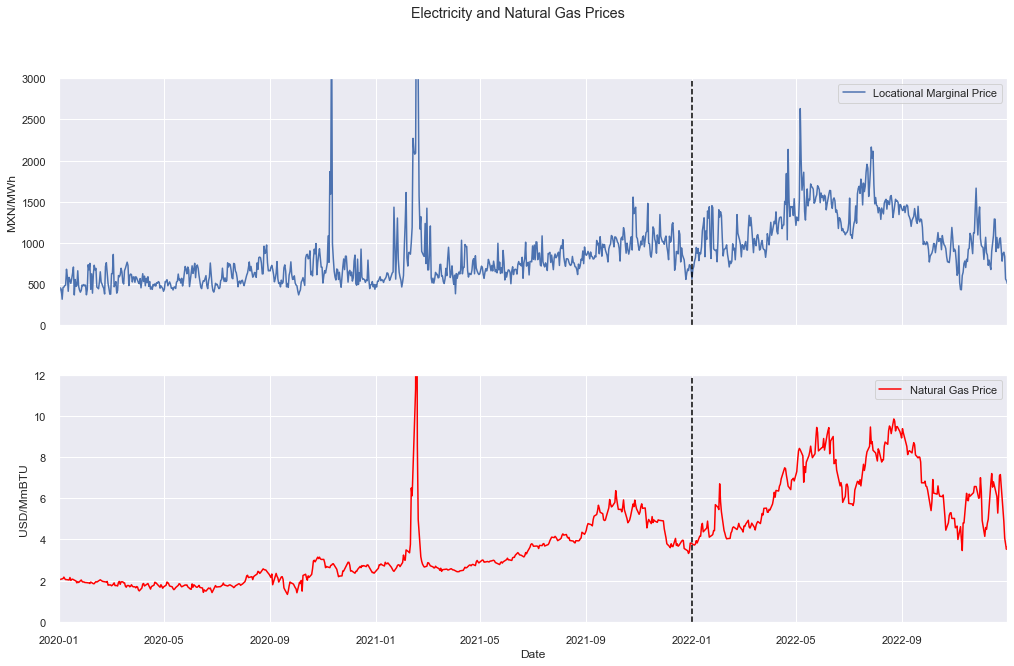

In [26]:
plt.rcParams["figure.figsize"] =[15,10]
fig,(ax1,ax2) = plt.subplots(2, figsize=(17,10),sharex=True)
fig.suptitle('Electricity and Natural Gas Prices')
sns.lineplot(ax=ax1,x=datosraw2.index,y=datosraw2['Precio Electricidad'],label='Locational Marginal Price').set(ylabel = "MXN/MWh")
sns.lineplot(ax=ax2,x=datosraw2.index,y=datosraw2['Precio Gas'],label='Natural Gas Price',color='red').set(ylabel = "USD/MmBTU")
ax1.set_xlim([datetime.date(2020, 1, 1), datetime.date(2022,12,31)])
ax1.set_ylim(0,3000)
ax2.set_ylim(0,12)

ax1.axvline(x=datetime.date(2022, 1, 1),color='black',linestyle='--')
ax2.axvline(x=datetime.date(2022, 1, 1),color='black',linestyle='--')

ax2.set_xlabel('Date')

Creando funciones para definición de variables exógenas y para cálculo de errores estadísticos

In [27]:
def calculate_model_accuracy_metrics(actual, predicted):
    mape = mean_absolute_percentage_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    rmae = rMAE(actual, predicted, m=None, freq='1H')
    smape = 100/len(actual) * np.sum(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted)))
    return mape*100,mae,mse,rmse,smape,rmae

In [28]:
datosraw2_mod = datosraw2.copy()
datosraw2_mod = datosraw2_mod.drop(columns=['Demanda','Eolica','Fotovoltaica','Hidroelectrica'])
datosraw2_mod.head(2)

,Precio Electricidad,Precio Gas
2020-01-01,316.654167,2.07
2020-01-02,416.863750,2.05


In [29]:
train = datosraw2_mod.loc[(datosraw2_mod.index >= '2020-01-01') & (datosraw2_mod.index <= '2021-12-31')]
test = datosraw2_mod.loc[(datosraw2_mod.index >= '2022-01-01') & (datosraw2_mod.index <= '2022-12-31')]

/////////////////////////// Análisis con SARIMAX //////////////////////

In [30]:
train_2exog = train.copy()
train_2exog = train_2exog.drop(columns=['Precio Electricidad'])

test_2exog = test.copy()
test_2exog = test_2exog.drop(columns=['Precio Electricidad'])


In [31]:
X_trainARIMA = train_2exog.to_numpy()
y_trainARIMA = train['Precio Electricidad'].values
y_trainARIMA = y_trainARIMA.reshape(-1,1)


X_testARIMA = test_2exog.to_numpy()
y_testARIMA = test['Precio Electricidad'].values
y_testARIMA = y_testARIMA.reshape(-1,1)

In [32]:
import warnings
warnings.filterwarnings('ignore')

arima = SARIMAX(endog=y_trainARIMA, exog=X_trainARIMA, order=(1,1,1),seasonal_order=(1,1,1,7))#seasonal_order(P,D,Q,M)
model = arima.fit()
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  731
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4865.856
Date:                           Sat, 03 Feb 2024   AIC                           9743.712
Time:                                   08:48:35   BIC                           9771.212
Sample:                                        0   HQIC                          9754.326
                                           - 731                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           123.7335      2.451     50.483      0.000     118.930     128.537
ar.L1          0.5827      0.008     74.627

In [33]:
y_predtrain = model.predict(n_periods=730, return_conf_int=True,exog=X_trainARIMA)

In [34]:
trainARIMAplot = data.copy()
trainARIMAplot = trainARIMAplot.drop(columns=['Precio Gas','Demanda','Eolica','Fotovoltaica','Hidroelectrica'])
df_dateindextrain = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
trainARIMAplot.set_index(df_dateindextrain, inplace=True)
trainARIMAplot = trainARIMAplot.loc[(trainARIMAplot.index >= '2020-01-01') & (trainARIMAplot.index <= '2021-12-31')]
trainARIMAplot['predicttrain'] = y_predtrain

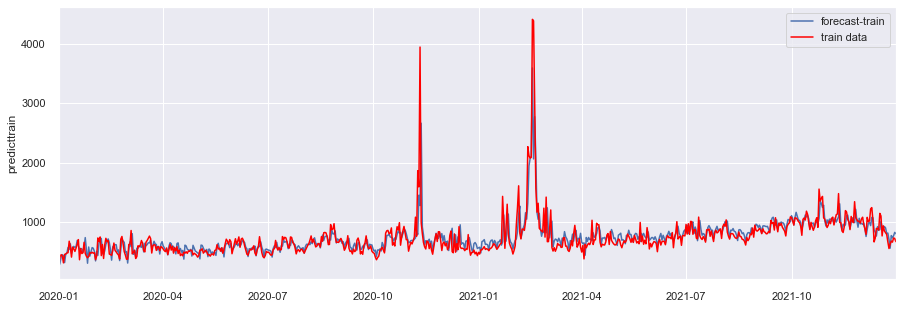

In [35]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x=trainARIMAplot.index,y=trainARIMAplot['predicttrain'],label='forecast-train')
sns.lineplot(x=trainARIMAplot.index,y=trainARIMAplot['Precio Electricidad'],label='train data', color='red')
ax.set_xlim([datetime.date(2020, 1, 1), datetime.date(2021,12,31)])
ax.legend(loc='upper right')

In [36]:
trainARIMAplot = trainARIMAplot.asfreq('d')
modeloARIMAtrain = pd.DataFrame(data=calculate_model_accuracy_metrics(trainARIMAplot['Precio Electricidad'],trainARIMAplot['predicttrain']), index=['MAPE', 'MAE','MSE','RMSE','sMAPE','rMAE'])
modeloARIMAtrain

,0
MAPE,13.412483
MAE,100.760933
MSE,39571.883133
RMSE,198.926829
sMAPE,12.829241
rMAE,0.756091


In [37]:
y_predtest = model.predict(start=731,end=1095,exog=X_testARIMA)

In [38]:
testARIMAplot = data.copy()
testARIMAplot = testARIMAplot.drop(columns=['Precio Gas','Demanda','Eolica','Fotovoltaica','Hidroelectrica'])
df_dateindex2 = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
testARIMAplot.set_index(df_dateindex2, inplace=True)
testARIMAplot = testARIMAplot.loc[(testARIMAplot.index >= '2022-01-01') & (testARIMAplot.index <= '2022-12-31')]
testARIMAplot['predicttest'] = y_predtest

Text(0.5, 0.98, 'EPF using SARIMAX Model')

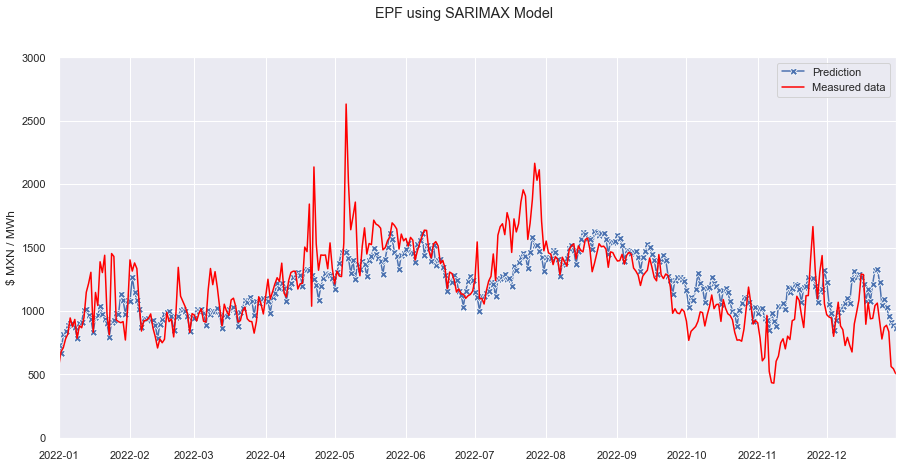

In [39]:
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(x=testARIMAplot.index,y=testARIMAplot['predicttest'],label='Prediction',marker = 'X',markersize=7).set(ylabel = "$ MXN / MWh")
sns.lineplot(x=testARIMAplot.index,y=testARIMAplot['Precio Electricidad'],label='Measured data',color='red')
ax.set_xlim([datetime.date(2022, 1, 1), datetime.date(2022,12,31)])
ax.set_ylim(0,3000)
ax.legend(loc='upper right')
fig.suptitle('EPF using SARIMAX Model')

In [40]:
testARIMAplot = testARIMAplot.asfreq('d')
modeloARIMAtest = pd.DataFrame(data=calculate_model_accuracy_metrics(testARIMAplot['Precio Electricidad'],testARIMAplot['predicttest']), index=['MAPE', 'MAE','MSE','RMSE','sMAPE','rMAE'])
modeloARIMAtest.columns = ['Modelo SARIMAX']
modeloARIMAtest

,Modelo SARIMAX
MAPE,14.601137
MAE,161.604692
MSE,48396.735142
RMSE,219.992580
sMAPE,13.823188
rMAE,1.294333


In [41]:
class SARIMAWrapper:
    def __init__(self, endog = None, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7), exog=None):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = arima
        self.exog = exog
        self.endog = endog
        
    def fit(self, X, y):
        self.model = SARIMAX(y, order=self.order, seasonal_order=self.seasonal_order, exog=X).fit(disp=False)
        return self
    def predict(self, X):
        if self.model is None:
            raise ValueError("Model not fit yet")
        return self.model.forecast(steps=len(X), exog=X)

    def get_params(self, deep=True):
        return {
            'order': self.order,
            'seasonal_order': self.seasonal_order,
            'exog': self.exog,
            'endog': self.endog
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [42]:
train_MLF = train.copy()
X_train_MLF = train_MLF.drop(['Precio Electricidad'], axis=1)#Defining the exogenous variables for training
X_train_MLF['ds'] = train_MLF.index

X_train_MLF['unique_id'] = 'TS1-X'
X_train_MLF.rename(columns = {'Precio Gas':'X'}, inplace = True)

y_train_MLF = train_MLF.drop(['Precio Gas'], axis=1)#Defining the endogenous variable for training
y_train_MLF['ds'] = train_MLF.index

y_train_MLF['unique_id'] = 'TS1'
y_train_MLF.rename(columns = {'Precio Electricidad':'y'}, inplace = True)


In [43]:
test_MLF = test.copy()
X_test_MLF = test_MLF.drop(['Precio Electricidad'], axis=1)#defining exogenous variables for test
X_test_MLF['ds'] = test_MLF.index
X_test_MLF['unique_id'] = 'TST1-X'
X_test_MLF.rename(columns = {'Precio Gas':'X'}, inplace = True)

y_test_MLF = test_MLF.drop(['Precio Gas'], axis=1)#defining endogenous variables for test
y_test_MLF['ds'] = test_MLF.index
y_test_MLF['unique_id'] = 'TST1'
y_test_MLF.rename(columns = {'Precio Electricidad':'y_test'}, inplace = True)

In [44]:
model = SARIMAWrapper(endog=y_train_MLF['y'].values.reshape(-1,1), order=(1,1,1), seasonal_order=(1,1,1,7), exog=X_train_MLF['X'].values.reshape(-1,1))

Using MAPIE library for PIs calculation

In [45]:
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap

alpha = 0.05
gap = 1

mapie_cv = BlockBootstrap(n_blocks=10, overlapping=True, random_state=42)

mapie_enbpi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=mapie_cv, agg_function="mean", n_jobs=1
)

In [46]:
mapie_enbpi = mapie_enbpi.fit(X_train_MLF['X'].values, y_train_MLF['y'].values)
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(
    X_test_MLF['X'].values, alpha=alpha, ensemble=True, optimize_beta=True
)

In [47]:
final_SARIMA2 = y_test_MLF.copy()
final_SARIMA2['pred'] = y_pred_npfit
final_SARIMA2['lower'] = y_pis_npfit[:, 0, 0]
final_SARIMA2['upper'] = y_pis_npfit[:, 1, 0]

(18993.0, 19357.0)

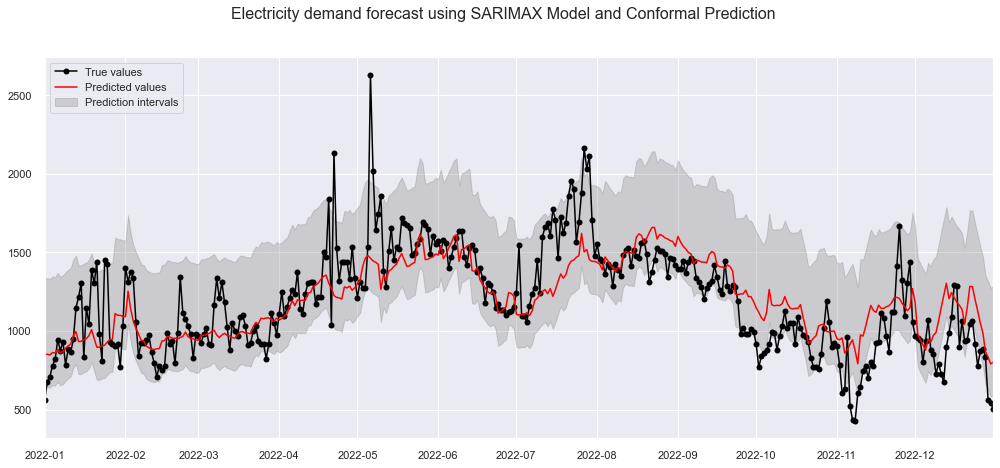

In [48]:
fig, (ax1) = plt.subplots(figsize=(17,7),sharex=True)
fig.suptitle('Electricity demand forecast using SARIMAX Model and Conformal Prediction', fontsize=16)
ax1.plot(final_SARIMA2.index, final_SARIMA2['y_test'], marker='o', label="True values", color='black')
ax1.plot(final_SARIMA2.index, final_SARIMA2['pred'].values, label="Predicted values", color='red')
ax1.fill_between(
    final_SARIMA2.index,
    final_SARIMA2['upper'].values,
    final_SARIMA2['lower'].values,
    alpha=0.3,
    label="Prediction intervals",
    color='gray'
)
ax1.legend(loc='upper left')
ax1.set_xlim([datetime.date(2022, 1, 1), datetime.date(2022,12,31)])

In [49]:
from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)

coverage = regression_coverage_score( final_SARIMA2['y_test'].values,
            final_SARIMA2['lower'].values, 
            final_SARIMA2['upper'].values)
width = regression_mean_width_score(final_SARIMA2['lower'].values, final_SARIMA2['upper'].values)

In [50]:
pd.options.display.float_format = '{:.2f}'.format
PI_display = pd.DataFrame(data=(coverage, width), index=['Coverage', 'Width'])
PI_display.columns = ['Modelo SARIMAX-CP']
PI_display

,Modelo SARIMAX-CP
Coverage,0.82
Width,691.17
